<a href="https://colab.research.google.com/github/VHKA1729/Machine-Learning/blob/master/Spambase_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Dataset**: Spambase Data Set [LINK](https://archive.ics.uci.edu/ml/datasets/Spambase)



# <center> $\mathbf {TABLE \ OF \ CONTENTS}$</center>

1. [Importing Libraries and Data](#paragraph1)

2. [Exploratory Data Analysis](#paragraph2)
    1. [On Whole Data](#wholedata)
    2. [Scaling Features](#subparagraph1)
    3. [Missing Values and Shape of Data](#subparagraph2)
    4. [Exploring Target](#subparagraph3)
    5. [Exploring Features](#subparagraph4)

3. [Model Building](#paragraph3)
    1. [Prelude](#subparagraph5)
    2. [Binary SVM with Linear Kernel](#subparagraph6)
    3. [Binary SVM with Quadratic Kernel](#subparagraph7)
    4. [Binary SVM with Radial Basis Function (RBF) Kernel](#subparagraph8)
    5. [Ensemble of SVMs](#subparagraph9)
    6. [Prediction and Scoring on Test Data](#subparagraph10)

4. [Discussion](#paragraph4)

The file was made using Google Colab and this piece of code just mounts `Google Drive`

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing Libraries and Data <a name="paragraph1"></a>

## Libraries 

In [0]:
import numpy as np
import pandas as pd
import random
import os
import gc

from scipy import stats
import time

from imblearn.over_sampling import SMOTE

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
#%matplotlib inline

#always close matplotlib plots

from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV, GridSearchCV 
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

from numba import jit, njit

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Make Everything Deterministic

This is essential so as to ensure that the obtained results are reproducible.

In [0]:
def seed_everything(SEED=1729):
    random.seed(SEED)
    os.environ['PYTHONHASHSEED'] = str(SEED)
    np.random.seed(SEED)

In [0]:
seed_everything()

## Memory Reduction 

In [0]:
def reduce_mem_usage(df, verbose=True):
    '''
    It takes a pandas DataFrame as input and assigns the minimum sufficient datatype to the columns so as to
    reduce the memory footprint of the DataFrame.
    '''
    start_mem = df.memory_usage(deep=True).sum() / 2**20
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] #defining a list of numeric types
    #start_mem = df.memory_usage().sum() / 2**20   #converting bytes into MB
    for col in tqdm(df.columns): # iterating over each column of dataframe
        col_type = df[col].dtypes # extracting the data type of a single column
        if col_type in numerics: # checking whether the data type of column is a numeric datatype or not
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int': #looking at the first 3 characters of the column type
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: #np.iinfo() gives the number of bits occupied by a type
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 2**20
    if verbose: print('Mem. usage decreased to {:5.5f} Mb ({:.2f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Import Data


In [0]:
df = pd.read_csv('spambase.data', sep=",", header=None)

In [0]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [0]:
df_names = pd.read_csv('spambaseNAMES.csv', sep="|", header=None)
df_names.drop(list(range(0,30)),axis=0, inplace=True)
df_names.reset_index(inplace=True)
df_names.drop([1,'index'],axis=1, inplace=True)
#df_names.head()
l = list(df_names[0].apply(lambda x: str(x).split(':')[0]))
print(len(l)-df.shape[1]+1)
#X.columns = l
l.append('target')
df.columns = l

0


In [0]:
del df_names
gc.collect()

0

In [0]:
df.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,target
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [0]:
df = reduce_mem_usage(df)


Mem. usage decreased to 0.50473 Mb (75.21% reduction)


In [0]:
y = df['target']
X = df.drop(['target'],axis=1)

In [0]:
X.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.000000,0.640137,0.640137,0.0,0.320068,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.640137,0.000000,0.000000,0.000000,0.320068,0.000000,1.290039,1.929688,0.000000,0.959961,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.777832,0.000000,0.000000,3.755859,61,278
1,0.209961,0.280029,0.500000,0.0,0.140015,0.280029,0.209961,0.070007,0.000000,0.939941,0.209961,0.790039,0.649902,0.209961,0.140015,0.140015,0.070007,0.280029,3.470703,0.000000,1.589844,0.0,0.429932,0.429932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.070007,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.131958,0.0,0.372070,0.180054,0.048004,5.113281,101,1028
2,0.059998,0.000000,0.709961,0.0,1.230469,0.189941,0.189941,0.119995,0.640137,0.250000,0.379883,0.449951,0.119995,0.000000,1.750000,0.059998,0.059998,1.030273,1.360352,0.320068,0.509766,0.0,1.160156,0.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.059998,0.0,0.0,0.119995,0.0,0.059998,0.059998,0.0,0.0,0.010002,0.142944,0.0,0.275879,0.183960,0.010002,9.820312,485,2259
3,0.000000,0.000000,0.000000,0.0,0.629883,0.000000,0.310059,0.629883,0.310059,0.629883,0.310059,0.310059,0.310059,0.000000,0.000000,0.310059,0.000000,0.000000,3.179688,0.000000,0.310059,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.136963,0.0,0.136963,0.000000,0.000000,3.537109,40,191
4,0.000000,0.000000,0.000000,0.0,0.629883,0.000000,0.310059,0.629883,0.310059,0.629883,0.310059,0.310059,0.310059,0.000000,0.000000,0.310059,0.000000,0.000000,3.179688,0.000000,0.310059,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.135010,0.0,0.135010,0.000000,0.000000,3.537109,40,191


In [0]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int8

### Train-test split

In [0]:
np.array([0,1])

array([0, 1])

In [0]:
# 30% data in test set
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, stratify=y)

In [0]:
l = X_train.columns

In [0]:
X_train.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
3694,0.000000,0.0,0.000000,0.0,2.019531,0.00000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,1.009766,0.0,0.000000,0.000000,0.000000,0.000000,1.009766,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,2.019531,0.000000,0.0,0.0,0.0,0.166016,0.166016,0.166016,0.000000,0.000000,0.000000,1.427734,6,40
1346,0.729980,0.0,0.360107,0.0,1.589844,0.00000,0.0,0.000000,0.239990,1.349609,0.72998,2.580078,0.609863,0.0,0.000000,0.609863,0.119995,0.000000,4.550781,0.0,1.719727,0.0,0.489990,0.97998,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.119995,0.0,0.0,0.0,0.000000,0.040985,0.000000,0.104004,0.229004,0.020004,3.705078,54,478
1723,0.000000,0.0,0.000000,0.0,0.000000,0.27002,0.0,0.000000,0.819824,0.000000,0.00000,0.270020,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0,0.540039,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.540039,0.0,0.0,0.540039,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.036987,0.225952,0.000000,0.036987,0.000000,0.000000,2.666016,33,208
164,0.459961,0.0,0.459961,0.0,0.000000,0.00000,0.0,0.459961,0.000000,0.000000,0.00000,1.379883,0.000000,0.0,2.310547,0.000000,0.459961,0.459961,2.769531,0.0,2.310547,0.0,1.379883,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.459961,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.489990,0.000000,0.080994,0.815918,0.000000,3.400391,12,102
4228,0.280029,0.0,0.280029,0.0,0.569824,0.00000,0.0,0.000000,0.000000,0.000000,0.00000,0.280029,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,2.869141,0.0,0.859863,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.154053,0.000000,0.308105,0.000000,0.000000,1.148438,4,54


# EDA <a name="paragraph2"></a>

## On Whole Data <a name="wholedata"></a>

We are just visualising the whole dataset. We will not use these inferences for feature selection or feature generation. Any feature selection or generation should come only from the training dataset.

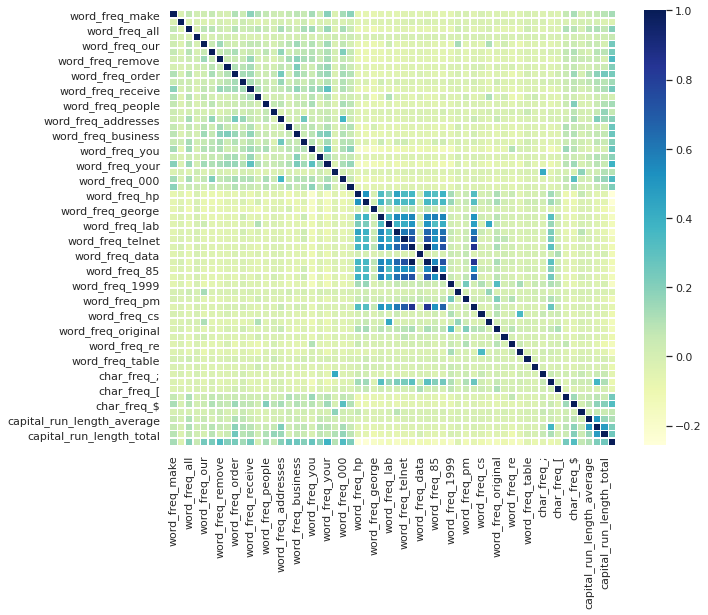

In [0]:
sns.set(rc={'figure.figsize':(10,8)})
corr=df.corr()
plt.figure() 
ax = sns.heatmap(corr,linewidths=.5, annot=False,cmap="YlGnBu")

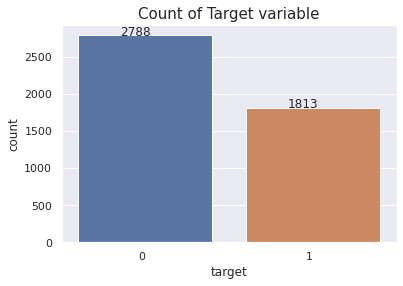

In [0]:
plt.figure(figsize=(6,4))
fig=sns.countplot(x='target', data = df)
fig
fig.set_xticklabels(fig.get_xticklabels(), ha="right")

plt.title('Count of Target variable',size = 15)

for p, label in zip(fig.patches,pd.DataFrame(df["target"].value_counts()).sort_index()['target']):
   fig.annotate(label, (p.get_x()+0.25, p.get_height()+0.5))

Correlation of features with target

In [0]:
df[df.columns[1:]].corr()['target'][:]

word_freq_address            -0.030228
word_freq_all                 0.196988
word_freq_3d                  0.057372
word_freq_our                 0.241912
word_freq_over                0.232606
word_freq_remove              0.332125
word_freq_internet            0.206810
word_freq_order               0.231542
word_freq_mail                0.138944
word_freq_receive             0.234533
word_freq_will                0.007740
word_freq_people              0.132925
word_freq_report              0.060033
word_freq_addresses           0.195896
word_freq_free                0.263220
word_freq_business            0.263201
word_freq_email               0.204200
word_freq_you                 0.273646
word_freq_credit              0.189740
word_freq_your                0.383225
word_freq_font                0.091859
word_freq_000                 0.334789
word_freq_money               0.216092
word_freq_hp                 -0.256724
word_freq_hpl                -0.232969
word_freq_george         

## Scaling Features <a name="subparagraph1"></a>

We have first made a train-test split and then done scaling.We have scaled `X_train` and then transformed `X_test`. 

**Note:** It is incorrect to scale or preprocess the values in the whole dataset before splitting it into training and test sets as it can lead to information leakage between the training and test sets.

* Scaling is done to avoid attributes in greater numeric ranges dominating those in smaller numeric ranges. Since SVM tries to maximize the distance between the separating plane and the support vectors, if one feature (i.e. one dimension in this space) has very large values, it will dominate the other features when calculating the distance. If we rescale all features (e.g. to $[0, 1]$), they all have the same influence on the distance metric.

* Another advantage is that we can avoid numerical difficulties during the calculation. Because kernel values usually depend on the inner products of feature vectors, large attribute values might cause numerical problems.

* Thus, scaling improves the quality of output as well as speeds up the processing.

* It should be noted that scaling and any kind of pre-processing that affects data values should
be done separately on the training and test set, so as to prevent leakage.

In [0]:
# Scaling the input
scaler = MinMaxScaler()

# fitting and transforming the training set
X_train = pd.DataFrame(scaler.fit_transform(X_train))

# transforming the test set
X_test = pd.DataFrame(scaler.transform(X_test))

## Missing Values and Shape of Data <a name="subparagraph2"></a>

In [0]:
print("The shape of training dataset is:", X_train.shape)
print("--"*40)
print("The shape of test dataset is:", X_test.shape)
print("--"*40)
if (X_train.isna().sum().sum()!=0):
  print("\t\t\tMissing Values in Train Dataset:")
  print("Column\t\t\t\t\t\t   Percentage of Missing Values")
  for i in tqdm(X_train.columns):
    percent = 100*X_train[i].isna().sum() / X.shape[0]
    if (X_train[i].isna().sum()!=0): print("{0:60} {1:3.2f} %".format(i,percent))

else: print("No Missing Values in Training Data")
print()

print("--"*40)

if (X_test.isna().sum().sum()!=0):
  print("\t\t\tMissing Values in Test Dataset:")
  print("Column\t\t\t\t\t\t   Percentage of Missing Values")
  for i in tqdm(X_test.columns):
    percent = 100*X_test[i].isna().sum() / test.shape[0]
    if (X_test[i].isna().sum()!=0): print("{0:60} {1:3.2f} %".format(i,percent))

else: print("No Missing Values in Testing Data")

The shape of training dataset is: (3220, 57)
--------------------------------------------------------------------------------
The shape of test dataset is: (1381, 57)
--------------------------------------------------------------------------------
No Missing Values in Training Data

--------------------------------------------------------------------------------
No Missing Values in Testing Data


## Exploring Target <a name="subparagraph3"></a>

In [0]:
y_train.value_counts()

0    1951
1    1269
Name: target, dtype: int64

Countplot of "target" showing moderately imbalanced data <a name="imbalance"></a>

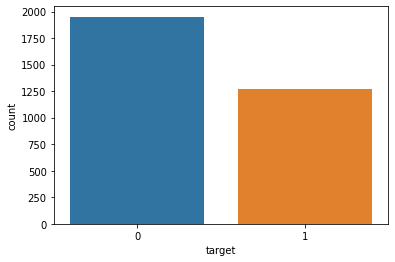

In [0]:
fig = sns.countplot(x=y_train)
plt.show()
plt.close()

## Exploring Features <a name="subparagraph4"></a>

In [0]:
def feature_table(df, description=None):
    #description is the description of the columns
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Approx Missing %'] = 100*summary['Missing']//df.shape[0]
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.iloc[0].values
    summary['Second Value'] = df.iloc[1].values
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 
    
    if (description!=None): summary['Description'] = pd.Series(description)

    return summary

In [0]:
X_train.columns = l

In [0]:
table = feature_table(X_train)

Dataset Shape: (3220, 57)


Feature Table <a name="featuretable"></a>

In [0]:
table

,Name,dtypes,Missing,Approx Missing %,Uniques,First Value,Second Value,Entropy
0,word_freq_make,float32,0,0,131,0.000000,0.160822,2.19
1,word_freq_address,float32,0,0,155,0.000000,0.000000,2.02
2,word_freq_all,float32,0,0,202,0.000000,0.070588,3.86
3,word_freq_3d,float32,0,0,32,0.000000,0.000000,0.13
4,word_freq_our,float32,0,0,235,0.242495,0.190901,3.76
5,word_freq_over,float32,0,0,131,0.000000,0.000000,2.15
6,word_freq_remove,float32,0,0,160,0.000000,0.000000,1.90
7,word_freq_internet,float32,0,0,144,0.000000,0.000000,1.86
8,word_freq_order,float32,0,0,131,0.000000,0.045611,1.79
9,word_freq_mail,float32,0,0,217,0.000000,0.121484,2.84


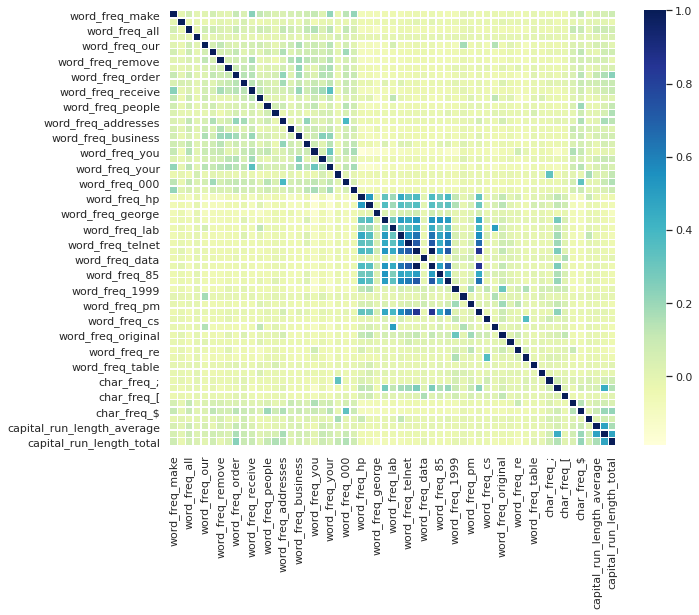

In [0]:
# Heatmap
sns.set(rc={'figure.figsize':(10,8)})
corr=X_train.corr()
plt.figure() 
ax = sns.heatmap(corr,linewidths=.5, annot=False,cmap="YlGnBu")

In [0]:
def kde(column,data=X_train):
  fig = sns.distplot(X_train[column])
  title = "Density Plot for "+ column
  plt.title(title)
  plt.show()

  del fig
  gc.collect()

  plt.close()

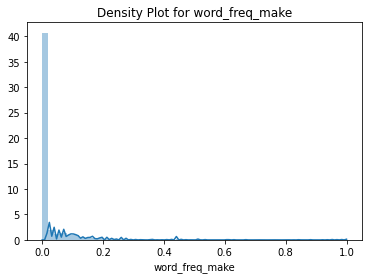

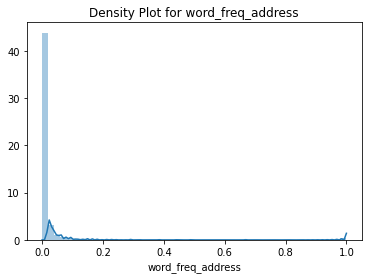

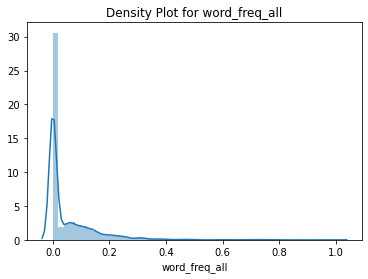

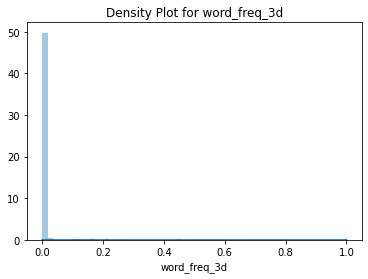

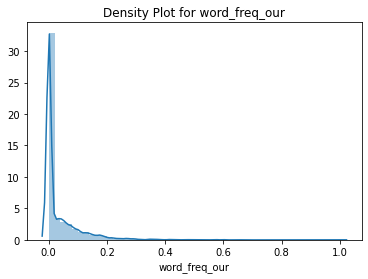

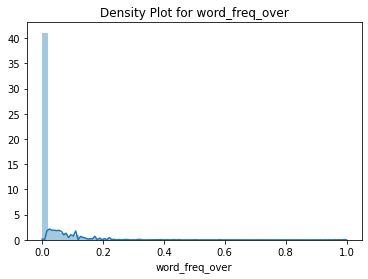

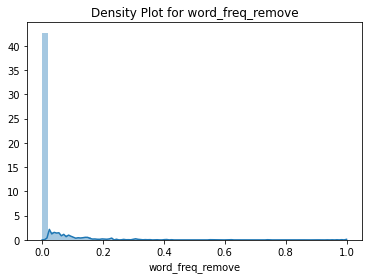

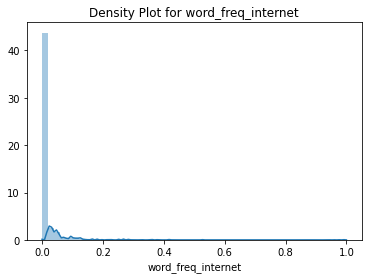

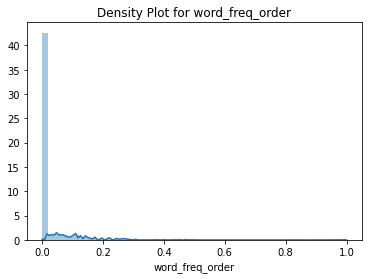

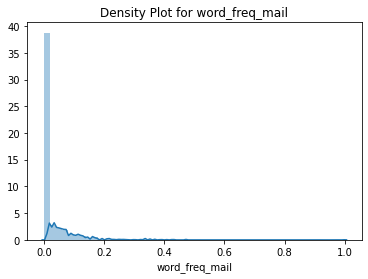

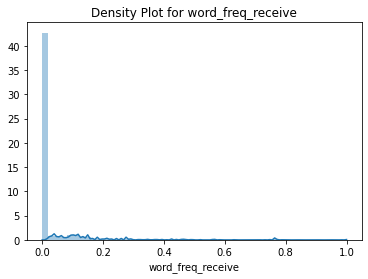

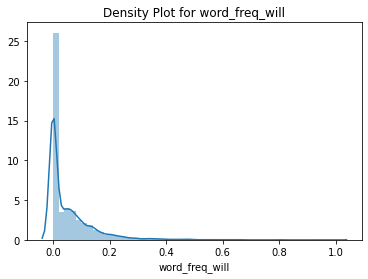

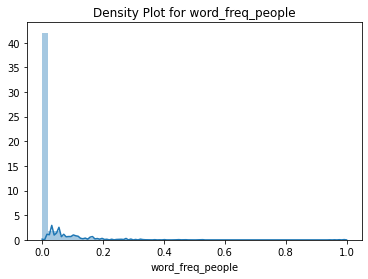

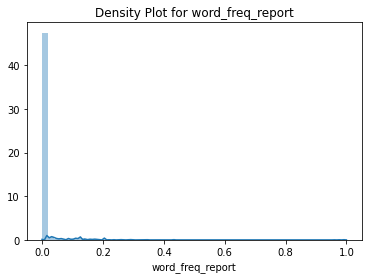

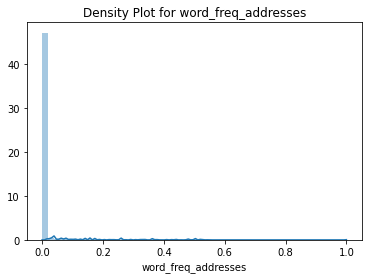

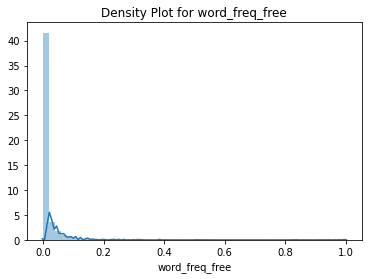

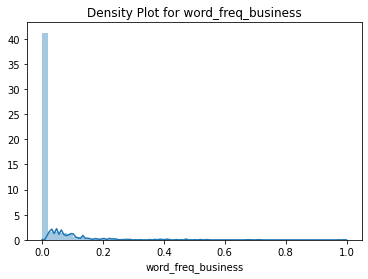

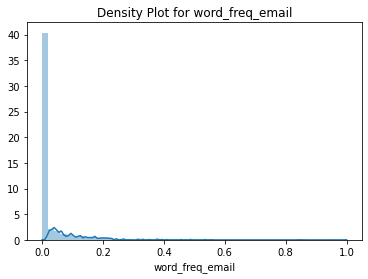

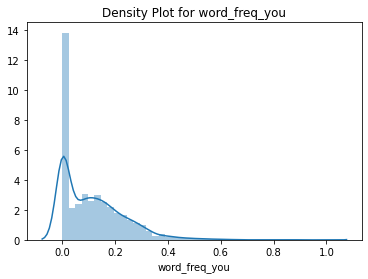

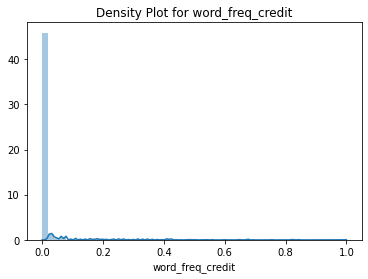

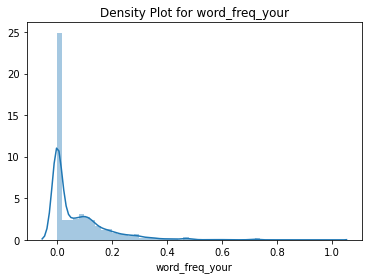

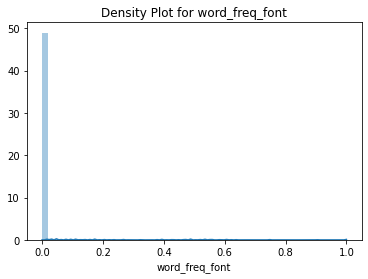

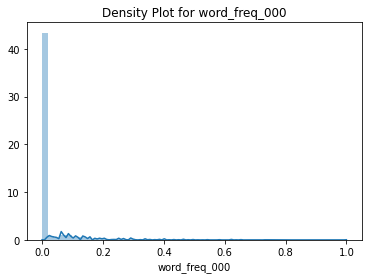

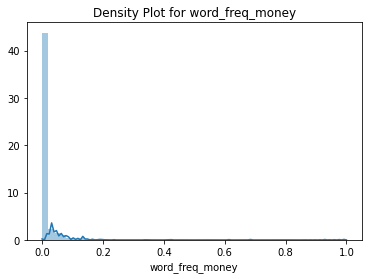

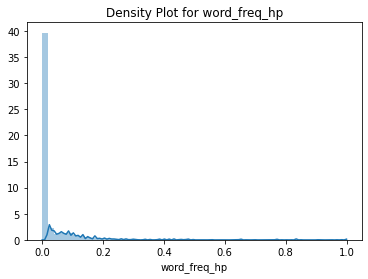

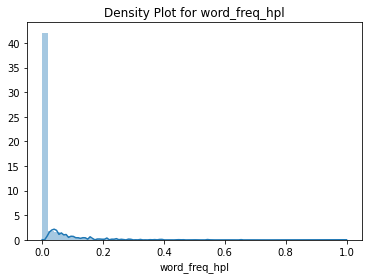

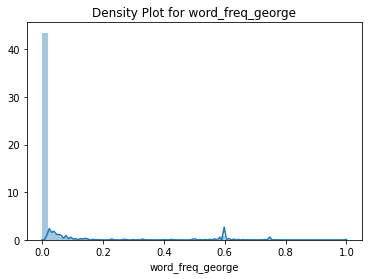

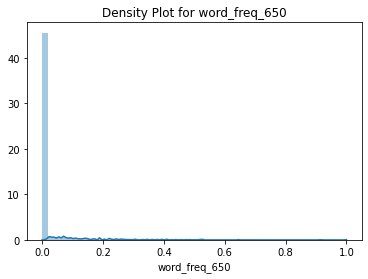

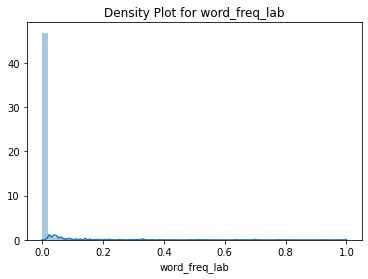

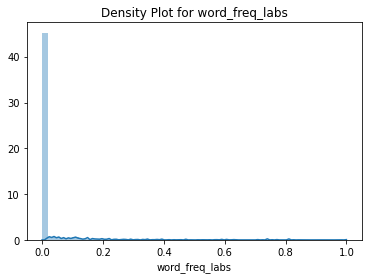

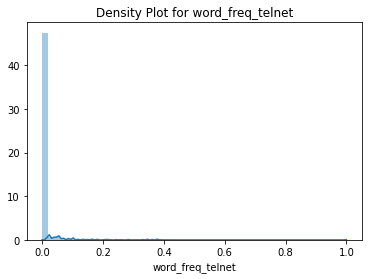

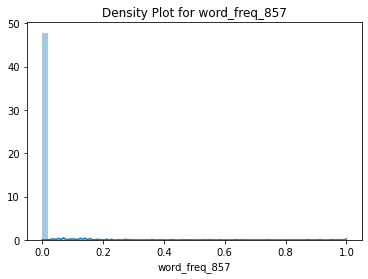

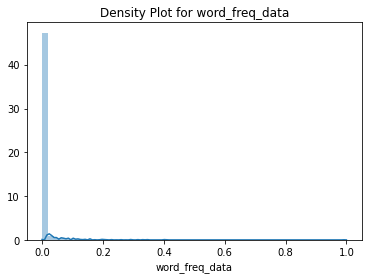

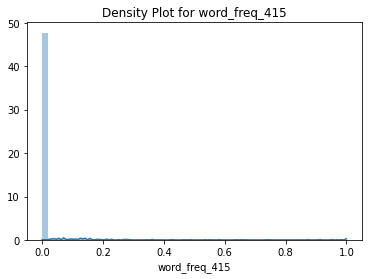

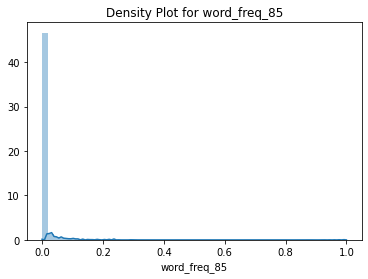

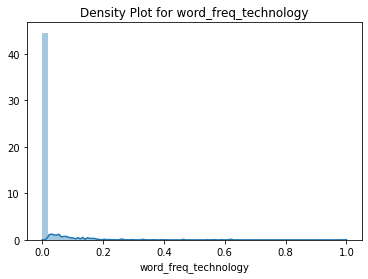

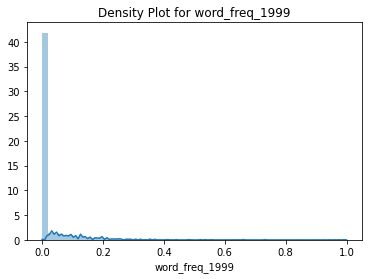

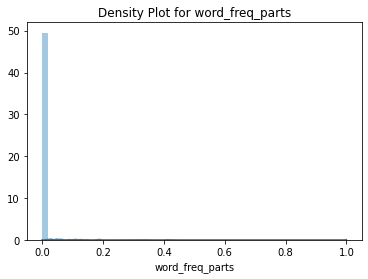

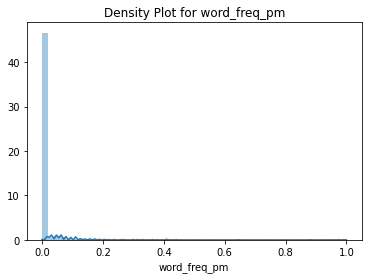

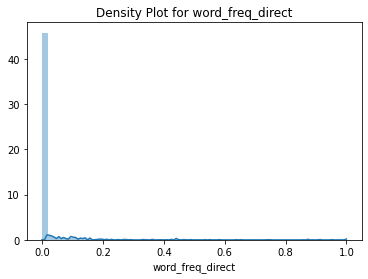

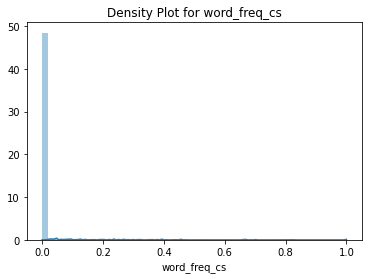

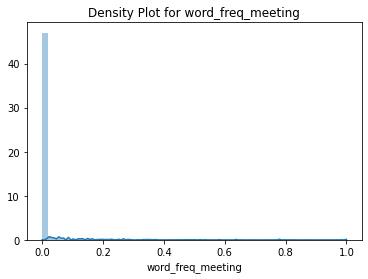

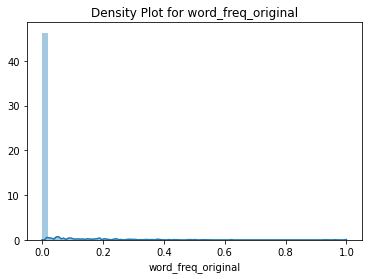

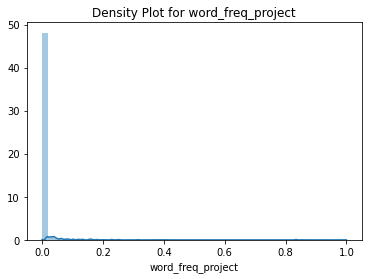

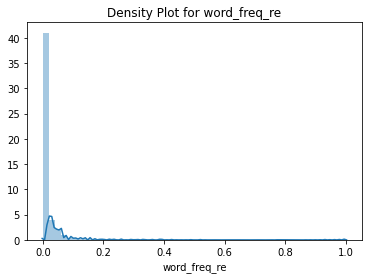

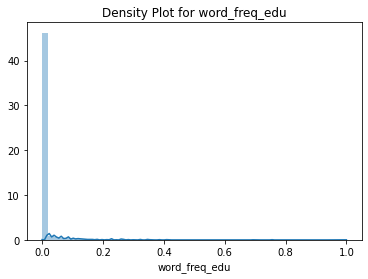

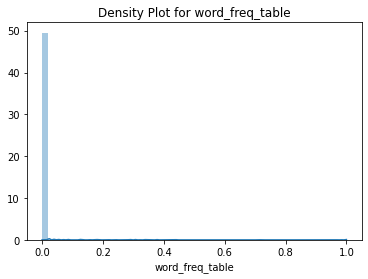

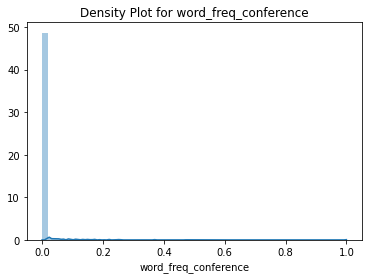

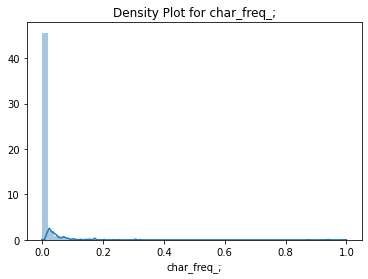

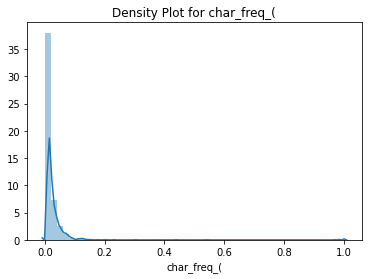

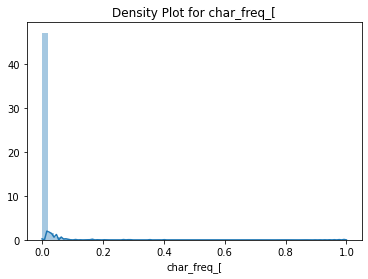

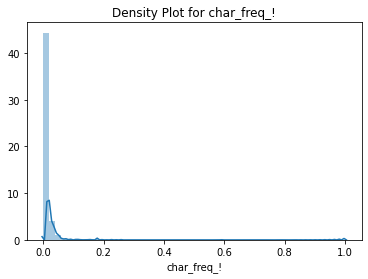

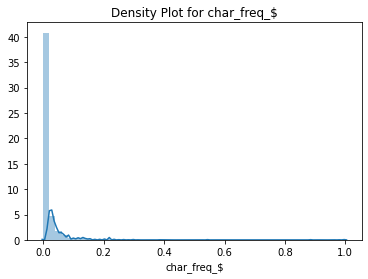

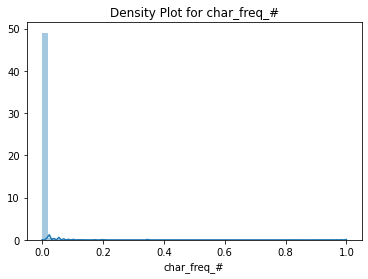

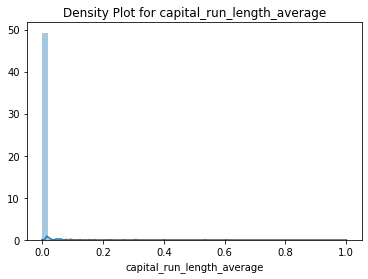

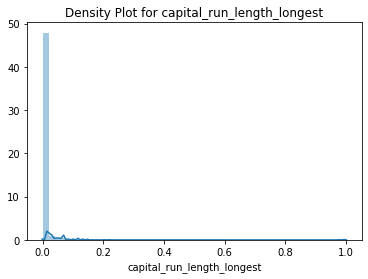

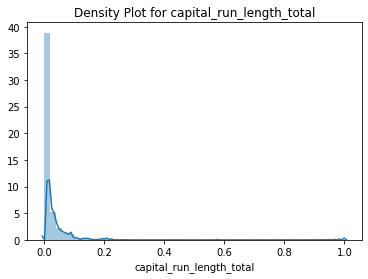

In [0]:
for i in (X_train.columns):
  kde(data=X_train,column=i)

# Model Building <a name="paragraph3"></a>

The SVM algorithm is implemented in practice using a kernel. A kernel transforms an input data space into the required form. 

SVM uses a technique called the **kernel trick**. Here, the kernel takes a low-dimensional input space and transforms it into a higher dimensional space. In other words, we can say that it converts nonseparable problem to separable problems by adding more dimension to it. It is most useful in non-linear separation problem. Kernel trick helps us to build a more accurate classifier.

The `C` parameter controls how much you want to punish your model for each misclassified point for a given curve: In other words, `C` is a **regularization parameter** for SVMs.

**Method:**

* We used `StratifiedKFold` which returns stratified folds. These folds are made by preserving the percentage of samples for each class.

* The hyper-parameter `C` was optimised by means of a GridSearch, implemented via the `GridSearchCV` module of `sklearn`.

* We parallelized the GridSearch over multiple CPU cores to speed up the SVM.

## Prelude <a name="subparagraph5"></a>

In [0]:
# Function for prediction
def predict_clf(clf, data=X_test, target=y_test):
  y_predicted = clf.predict(data)
  print(f"Accuracy Score = {accuracy_score(target,y_predicted):.4f}")
  print()
  print("Classification Report:\n", classification_report(target,y_predicted))

In [0]:
# Creating the estimators
# Linear
estimator_linear = SVC(kernel='linear')

# Quadratic
estimator_poly = SVC(kernel='poly', degree=2)

# RBF
estimator_rbf = SVC(kernel='rbf')

# Ensemble
estimator_vote = VotingClassifier(estimators = [('lin',estimator_linear),
                  ('poly',estimator_poly),
                  ('rbf',estimator_rbf)
                  ],
                  voting = 'hard'
)

**Cross-validation Grid search for Selection of best C**

Cross-validation is a method for robustly estimating test-set performance (generalization) of a model. Grid-search is a way to select the best of a family of models, parametrized by a grid of parameters.

Grid search is a method to perform *hyper-parameter optimisation*, that is, it is a method to find the best combination of hyper-parameters, for a given model and test dataset. In this scenario, you have several models, each with a different combination of hyper-parameters. Each of these combinations of parameters, which correspond to a single model, can be said to lie on a point of a "grid". The goal is then to train each of these models and evaluate them e.g. using cross-validation. We then select the one that performed best.

For example, in a support vector machine, we could use different values for gamma and C. So, for example, we could have a grid with the following values for (gamma, C): (1, 1), (0.1, 1), (1, 10), (0.1, 10). It's a grid because it's like a product of [1, 0.1] for gamma and [1, 10] for C. Grid-search would basically train a SVM for each of these four pair of (gamma, C) values, then evaluate it using cross-validation, and select the one that did best.

In [0]:
# Creating cross-validation folds
kf = StratifiedKFold(n_splits=10, shuffle=True)

In [0]:
# Creating parameter grid for gridsearch

# Parameter dictionary for each binary SVM with linear, quadratic, and rbf kernels
param_dict_svm = { 'C':[0.1,1.0,10,50,100,1000]
              }

# Parameter dictionary for ensemble of binary SVMs with linear, quadratic, and rbf kernels
param_dict_vote = { 'lin__C':[0.1,1.0,10,50,100,1000],
                   'poly__C':[0.1,1.0,10,50,100,1000],
                   'rbf__C':[0.1,1.0,10,50,100,1000]
                   }

## Binary SVM with Linear Kernel <a name="subparagraph6"></a>

A linear kernel can be used as normal dot product any two given observations. The product between two vectors is the sum of the multiplication of each pair of input values.

$$K(x, xi) = sum(x * xi)$$

In [0]:
clf_linear = GridSearchCV(estimator=estimator_linear,
                          param_grid = param_dict_svm,
                          scoring='accuracy',
                          cv=kf,
                          n_jobs=-1
                          )

In [0]:
%%time
#tick = time.time()

temp = clf_linear.fit(X_train,y_train)

#print(f"Binary SVM with linear kernel took {(time.time()-tick):.2f} seconds for fitting to training data")

CPU times: user 1.56 s, sys: 80.3 ms, total: 1.64 s
Wall time: 22.2 s


In [0]:
print(f"{clf_linear.best_params_} is the best value of parameter")
print()
print(f"{clf_linear.best_score_:.4f} is the best cross-validation score")

{'C': 1000} is the best value of parameter

0.9339 is the best cross-validation score


In [0]:
#print("For the Whole Training Dataset")

print("Classifier: Binary SVM with Linear Kernel")
print("Data: Training Dataset")
print()
predict_clf(clf_linear,data=X_train,target=y_train)

Classifier: Binary SVM with Linear Kernel
Data: Training Dataset

Accuracy Score = 0.9388

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1951
           1       0.94      0.91      0.92      1269

    accuracy                           0.94      3220
   macro avg       0.94      0.93      0.94      3220
weighted avg       0.94      0.94      0.94      3220



In [0]:
del temp
gc.collect()

582

## Binary SVM with Quadratic Kernel <a name="subparagraph7"></a>

A Quadratic kernel is a more generalized form of the linear kernel. The Quadratic kernel can distinguish nonlinear input space.

$$K(x,xi) = 1 + sum(x * xi)^d$$ , where we set $d=2$ for Quadratic kernel

In [0]:
clf_poly = GridSearchCV(estimator=estimator_poly,
                        param_grid = param_dict_svm,
                        scoring='accuracy',
                        cv=kf,
                        n_jobs=-1
                        )

In [0]:
%%time
#tick = time.time()

temp = clf_poly.fit(X_train,y_train)

#print(f"Binary SVM with quadratic kernel took {(time.time()-tick):.2f} seconds for fitting to training data")

CPU times: user 807 ms, sys: 39 ms, total: 846 ms
Wall time: 24.8 s


In [0]:
print(f"{clf_poly.best_params_} is the best value of parameter")
print()
print(f"{clf_poly.best_score_:.4f} is the best cross-validation score")

{'C': 100} is the best value of parameter

0.9258 is the best cross-validation score


In [0]:
#print("For the Whole Training Dataset")

print("Classifier: Binary SVM with Quadratic Kernel")
print("Data: Training Dataset")
print()
predict_clf(clf_poly,data=X_train,target=y_train)

Classifier: Binary SVM with Quadratic Kernel
Data: Training Dataset

Accuracy Score = 0.9693

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98      1951
           1       0.99      0.94      0.96      1269

    accuracy                           0.97      3220
   macro avg       0.97      0.96      0.97      3220
weighted avg       0.97      0.97      0.97      3220



In [0]:
del temp
gc.collect()

672

## Binary SVM with RBF Kernel <a name="subparagraph8"></a>

The Radial Basis Function kernel (RBF) can map an input space in infinite dimensional space.

$$K(x,xi) = exp(-gamma * sum((x – xi^2))$$

In [0]:
clf_rbf = GridSearchCV(estimator=estimator_rbf,
                       param_grid = param_dict_svm,
                       scoring='accuracy',
                       cv=kf,
                       n_jobs=-1
                       )

In [0]:
%%time
#tick=time.time()

temp=clf_rbf.fit(X_train,y_train)

#print(f"Binary SVM with rbf kernel took {(time.time()-tick):.2f} seconds for fitting to training data")

CPU times: user 739 ms, sys: 33.1 ms, total: 772 ms
Wall time: 16.7 s


In [0]:
print(f"{clf_rbf.best_params_} is the best value of parameter")
print()
print(f"{clf_rbf.best_score_:.4f} is the best cross-validation score")

{'C': 10} is the best value of parameter

0.9317 is the best cross-validation score


In [0]:
#print("For the Whole Training Dataset")
print("Classifier: Binary SVM with RBF Kernel")
print("Data: Training Dataset")
print()
predict_clf(clf_rbf,data=X_train,target=y_train)

Classifier: Binary SVM with RBF Kernel
Data: Training Dataset

Accuracy Score = 0.9671

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1951
           1       0.97      0.94      0.96      1269

    accuracy                           0.97      3220
   macro avg       0.97      0.96      0.97      3220
weighted avg       0.97      0.97      0.97      3220



In [0]:
del temp
gc.collect()

636

## Ensemble of SVMs <a name="subparagraph9"></a>

In [0]:
clf_vote = GridSearchCV(estimator=estimator_vote,
                       param_grid = param_dict_vote,
                       scoring='accuracy',
                       cv=kf,
                       n_jobs=-1
                        )

In [0]:
%%time
#tick=time.time()

temp = clf_vote.fit(X_train,y_train)

#print(f"Ensemble of binary SVMs took {(time.time()-tick):.2f} seconds for fitting to training data")

CPU times: user 16.6 s, sys: 1.15 s, total: 17.7 s
Wall time: 36min 18s


In [0]:
print(f"{clf_vote.best_params_} is the best value of parameter")
print()
print(f"{clf_vote.best_score_:.4f} is the best cross-validation score")

{'lin__C': 100, 'poly__C': 100, 'rbf__C': 10} is the best value of parameter

0.9404 is the best cross-validation score


In [0]:
#print("For the Whole Training Dataset")
print("Classifier: Ensemble Classifier")
print("Data: Training Dataset")
print()
predict_clf(clf_vote,data=X_train,target=y_train)

Classifier: Ensemble Classifier
Data: Training Dataset

Accuracy Score = 0.9655

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97      1951
           1       0.98      0.94      0.96      1269

    accuracy                           0.97      3220
   macro avg       0.97      0.96      0.96      3220
weighted avg       0.97      0.97      0.97      3220



In [0]:
del temp
gc.collect()

426

## Prediction and Scoring on Test Data <a name="subparagraph10"></a>

In [0]:
print("--"*40)
print("For Test Data")
print("--"*40)
for j,i in [('Binary SVM with Linear Kernel',clf_linear),('Binary SVM with Quadratic Kernel',clf_poly),('Binary SVM with RBF Kernel',clf_rbf),('Ensemble Classifier',clf_vote)]: 
  print("Classifier:", j)
  print("Data: Test Dataset")
  #print("Mean cross-validation score of best classifier: ",i.best_score_)
  #print("Parameters of the best classifier: ",i.best_params_)
  #print("Evaluation of the best classifier on test data")
  
  predict_clf(i)
  print("--"*40)

--------------------------------------------------------------------------------
For Test Data
--------------------------------------------------------------------------------
Classifier: Binary SVM with Linear Kernel
Data: Test Dataset
Accuracy Score = 0.9247

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       837
           1       0.91      0.90      0.90       544

    accuracy                           0.92      1381
   macro avg       0.92      0.92      0.92      1381
weighted avg       0.92      0.92      0.92      1381

--------------------------------------------------------------------------------
Classifier: Binary SVM with Quadratic Kernel
Data: Test Dataset
Accuracy Score = 0.9283

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.94       837
           1       0.93      0.88      0.91       544

    accuracy                 

# Discussion <a name="paragraph4"></a>

## Entropy of Features
There are certain features with small values of entropy as can be seen from the [feature table](#featuretable). To improve the classification result, some
more feature engineering combined with feature selection shall be used.

##Imbalanced Dataset

**Metric:** 

The dataset is moderately imbalanced as can be seen from the [figure](#imbalance). Hence, accuracy may not be the best metric to evaluate the output. Better metrics can be “balanced accuracy”, “f1-score”,
“AUC score”, “Precision”,”Recall”. 

In fact, the quality of the classifiers should be evaluated using
the ROC-AUC Curve or by the Precision-Recall curve.

**Handling Imbalanced Datasets:** 

The imbalanced dataset can be handled and performance can be
improved by using oversampling and/or undersampling techniques. The python library for implementing this is “imbalanced-learn” (`imblearn`)

## If `Precision` is Used as Evaluation Metric

Since this is a task for spam classification, a better metric to optimize would be `precision` since false positives can be disastrous as compared to false negatives. Further, the dataset is moderately imbalanced.


### Binary SVM with Linear Kernel Using Precision

In [0]:
clf_linear_p = GridSearchCV(estimator=estimator_linear,
                          param_grid = param_dict_svm,
                          scoring='precision',
                          cv=kf,
                          n_jobs=-1
                          )

In [0]:
%%time
#tick = time.time()

temp = clf_linear_p.fit(X_train,y_train)

#print(f"Binary SVM with linear kernel took {(time.time()-tick):.2f} seconds for fitting to training data")

CPU times: user 790 ms, sys: 66.1 ms, total: 856 ms
Wall time: 21.4 s


In [0]:
print(f"{clf_linear_p.best_params_} is the best value of parameter")
print()
print(f"{clf_linear_p.best_score_:.4f} is the best cross-validation score")

{'C': 100} is the best value of parameter

0.9300 is the best cross-validation score


In [0]:
#print("For the Whole Training Dataset")

print("Classifier: Binary SVM with Linear Kernel")
print("Data: Training Dataset")
print()
predict_clf(clf_linear_p,data=X_train,target=y_train)

Classifier: Binary SVM with Linear Kernel
Data: Training Dataset

Accuracy Score = 0.9370

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.96      0.95      1951
           1       0.94      0.90      0.92      1269

    accuracy                           0.94      3220
   macro avg       0.94      0.93      0.93      3220
weighted avg       0.94      0.94      0.94      3220



In [0]:
del temp
gc.collect()

726

### Binary SVM with Quadratic Kernel Using Precision

In [0]:
clf_poly_p = GridSearchCV(estimator=estimator_poly,
                        param_grid = param_dict_svm,
                        scoring='precision',
                        cv=kf,
                        n_jobs=-1
                        )

In [0]:
%%time
#tick = time.time()

temp = clf_poly_p.fit(X_train,y_train)

#print(f"Binary SVM with quadratic kernel took {(time.time()-tick):.2f} seconds for fitting to training data")

CPU times: user 709 ms, sys: 39.1 ms, total: 748 ms
Wall time: 25 s


In [0]:
print(f"{clf_poly_p.best_params_} is the best value of parameter")
print()
print(f"{clf_poly_p.best_score_:.4f} is the best cross-validation score")

{'C': 1.0} is the best value of parameter

0.9405 is the best cross-validation score


In [0]:
#print("For the Whole Training Dataset")

print("Classifier: Binary SVM with Quadratic Kernel")
print("Data: Training Dataset")
print()
predict_clf(clf_poly_p,data=X_train,target=y_train)

Classifier: Binary SVM with Quadratic Kernel
Data: Training Dataset

Accuracy Score = 0.9012

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      1951
           1       0.96      0.78      0.86      1269

    accuracy                           0.90      3220
   macro avg       0.92      0.88      0.89      3220
weighted avg       0.91      0.90      0.90      3220



In [0]:
del temp
gc.collect()

654

### Binary SVM with RBF Kernel Using Precision

In [0]:
clf_rbf_p = GridSearchCV(estimator=estimator_rbf,
                       param_grid = param_dict_svm,
                       scoring='precision',
                       cv=kf,
                       n_jobs=-1
                       )

In [0]:
%%time
#tick=time.time()

temp=clf_rbf_p.fit(X_train,y_train)

#print(f"Binary SVM with rbf kernel took {(time.time()-tick):.2f} seconds for fitting to training data")

CPU times: user 806 ms, sys: 32.8 ms, total: 839 ms
Wall time: 16.9 s


In [0]:
print(f"{clf_rbf_p.best_params_} is the best value of parameter")
print()
print(f"{clf_rbf_p.best_score_:.4f} is the best cross-validation score")

{'C': 1.0} is the best value of parameter

0.9332 is the best cross-validation score


In [0]:
#print("For the Whole Training Dataset")
print("Classifier: Binary SVM with RBF Kernel")
print("Data: Training Dataset")
print()
predict_clf(clf_rbf_p,data=X_train,target=y_train)

Classifier: Binary SVM with RBF Kernel
Data: Training Dataset

Accuracy Score = 0.9460

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      1951
           1       0.95      0.91      0.93      1269

    accuracy                           0.95      3220
   macro avg       0.95      0.94      0.94      3220
weighted avg       0.95      0.95      0.95      3220



In [0]:
del temp
gc.collect()

654

### Ensemble of SVMs Using Precision <a name="here"></a>

In [0]:
# This parameter dictionary has been arrived at my modifying for optimum C values and making the grid finer.
param_dict_vote_p = { 'lin__C':[0.5,1.0,5],
                   'poly__C':[5,10,15],
                   'rbf__C':[150,200]
                   }

In [0]:
clf_vote_p = GridSearchCV(estimator=estimator_vote,
                       param_grid = param_dict_vote_p,
                       scoring='precision',
                       cv=kf,
                       n_jobs=-1
                        )

In [0]:
%%time
#tick=time.time()

temp = clf_vote_p.fit(X_train,y_train)

#print(f"Ensemble of binary SVMs took {(time.time()-tick):.2f} seconds for fitting to training data")

CPU times: user 2.49 s, sys: 107 ms, total: 2.6 s
Wall time: 2min 9s


In [0]:
print(f"{clf_vote_p.best_params_} is the best value of parameter")
print()
print(f"{clf_vote_p.best_score_:.4f} is the best cross-validation score")

{'lin__C': 1.0, 'poly__C': 5, 'rbf__C': 200} is the best value of parameter

0.9430 is the best cross-validation score


In [0]:
#print("For the Whole Training Dataset")
print("Classifier: Ensemble Classifier")
print("Data: Training Dataset")
print()
predict_clf(clf_vote_p,data=X_train,target=y_train)

Classifier: Ensemble Classifier
Data: Training Dataset

Accuracy Score = 0.9419

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95      1951
           1       0.97      0.88      0.92      1269

    accuracy                           0.94      3220
   macro avg       0.95      0.93      0.94      3220
weighted avg       0.94      0.94      0.94      3220



In [0]:
del temp
gc.collect()

822

### Prediction and Scoring on Test Data After Training with Precision as the Evaluation Metric

In [0]:
print("--"*40)
print("For Test Data")
print("--"*40)
for j,i in [('Binary SVM with Linear Kernel',clf_linear_p),('Binary SVM with Quadratic Kernel',clf_poly_p),('Binary SVM with RBF Kernel',clf_rbf_p),('Ensemble Classifier',clf_vote_p)]: 
  print("Classifier:", j)
  print("Data: Test Dataset")
  #print("Mean cross-validation score of best classifier: ",i.best_score_)
  #print("Parameters of the best classifier: ",i.best_params_)
  #print("Evaluation of the best classifier on test data")
  predict_clf(i)
  print("--"*40)

--------------------------------------------------------------------------------
For Test Data
--------------------------------------------------------------------------------
Classifier: Binary SVM with Linear Kernel
Data: Test Dataset
Accuracy Score = 0.9211

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.94      0.94       837
           1       0.91      0.89      0.90       544

    accuracy                           0.92      1381
   macro avg       0.92      0.92      0.92      1381
weighted avg       0.92      0.92      0.92      1381

--------------------------------------------------------------------------------
Classifier: Binary SVM with Quadratic Kernel
Data: Test Dataset
Accuracy Score = 0.8755

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90       837
           1       0.92      0.75      0.83       544

    accuracy                 

## Possible Improvements

* The ensemble algorithm can be run faster by optimising the individual estimators. For instance, instead of using `SVC()` module to implement linear SVM, we can use `LinearSVC()`, which has been implemented in liblinear, and hence, scales better.

* We can also use `SGDClassifier()` for implementing the SVM algorithm using Stochastic Gradient Descent (SGD).

* Still another way is to train different ensembles on portions of data and then use boosting.

* We should progressively go on making the grid finer and eliminate extraneous values. This will decrease the time taken by grid search. This has been demonstrated [here](#here).

Although, empirically, we can see that small changes in `C`, don't create much impact in final performance on test set as far as accuracy or precision is concerned. However, the training process does get completed faster.